In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
cwd = os.getcwd()

api_path = os.path.join(cwd, '..', 'tools')
sys.path.append(api_path)

In [3]:
import numpy as np
import random
import sklearn

from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F


from sir_ais_sampling import (run_experiments_gaussians,
                              sir_correlated_dynamics,
                              sir_independent_dynamics)

from distributions import (Target, 
                           Gaussian_mixture, 
                           IndependentNormal,
                           init_independent_normal)

from metrics import Evolution
from utils import DotDict

# SIR, target = 1 gaussian

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
dim_arr = [30*(i + 1) for i in range(9)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1
n_steps = 60000
N = 10
method_params = {'n_steps': n_steps, 'N': N}
random_seed = 42
method = 'sir_independent' 
print_results = True
results_independent = run_experiments_gaussians(dim_arr,  
                                                scale_proposal, 
                                                scale_target, 
                                                num_points_in_chain, 
                                                strategy_mean,
                                                device,
                                                batch_size,
                                                method_params,
                                                random_seed,
                                                method,
                                                print_results)

------------------
mode = target
dim = 30
mean estimation of variance = 1.0061782598495483
mean estimation of mean = 0.01278663519769907
mean estimation of ess = 0.2676267626762676
------
dim = 60
mean estimation of variance = 0.8921854496002197
mean estimation of mean = 0.003313018474727869
mean estimation of ess = 0.0333033303330333
------
dim = 90
mean estimation of variance = 0.7449384331703186
mean estimation of mean = -0.005054965149611235
mean estimation of ess = 0.008500850085008501
------
dim = 120
mean estimation of variance = 3.863663611269885e-09
mean estimation of mean = -0.043878164142370224
mean estimation of ess = 0.0
------
dim = 150
mean estimation of variance = 3.916035939965923e-09
mean estimation of mean = -0.013066168874502182
mean estimation of ess = 0.0
------
dim = 180
mean estimation of variance = 3.838620088458811e-09
mean estimation of mean = -0.03700427711009979
mean estimation of ess = 0.0
------
dim = 210
mean estimation of variance = 3.790504354839186e-0

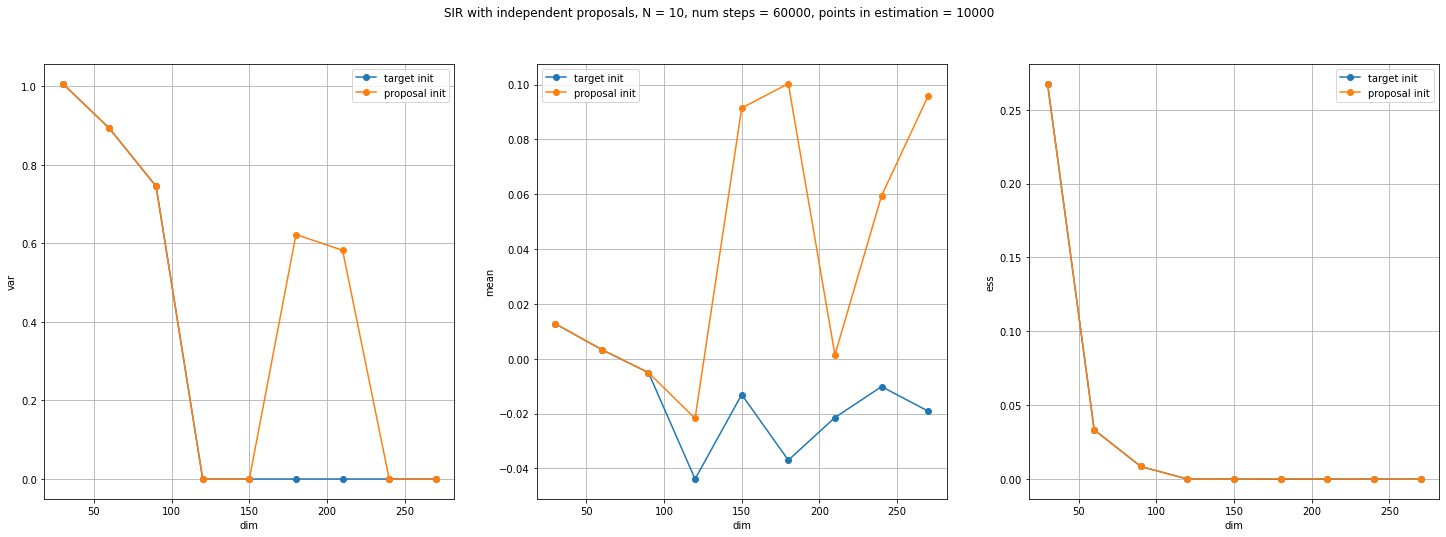

In [13]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(25, 8))
name = f'SIR with independent proposals, N = {N}, num steps = {n_steps}, points in estimation = {num_points_in_chain}'
fig.suptitle(name)

#axs[0].axhline(var_target, label='real', color='black')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('var')

#axs[1].axhline(0.0, label='real', color='black')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('mean')

#axs[2].axhline(0.0, label='real', color='black')
axs[2].set_xlabel('dim')
axs[2].set_ylabel('ess')

modes_to_plot = ['mean_var', 'mean_loc', 'ess']
for i, mode in enumerate(modes_to_plot):
    axs[i].plot(dim_arr, results_independent['target'][mode], label='target init', marker='o')
    axs[i].plot(dim_arr, results_independent['proposal'][mode], label='proposal init', marker='o')

for ax in axs:
    ax.grid()
    ax.legend()

plt.show()

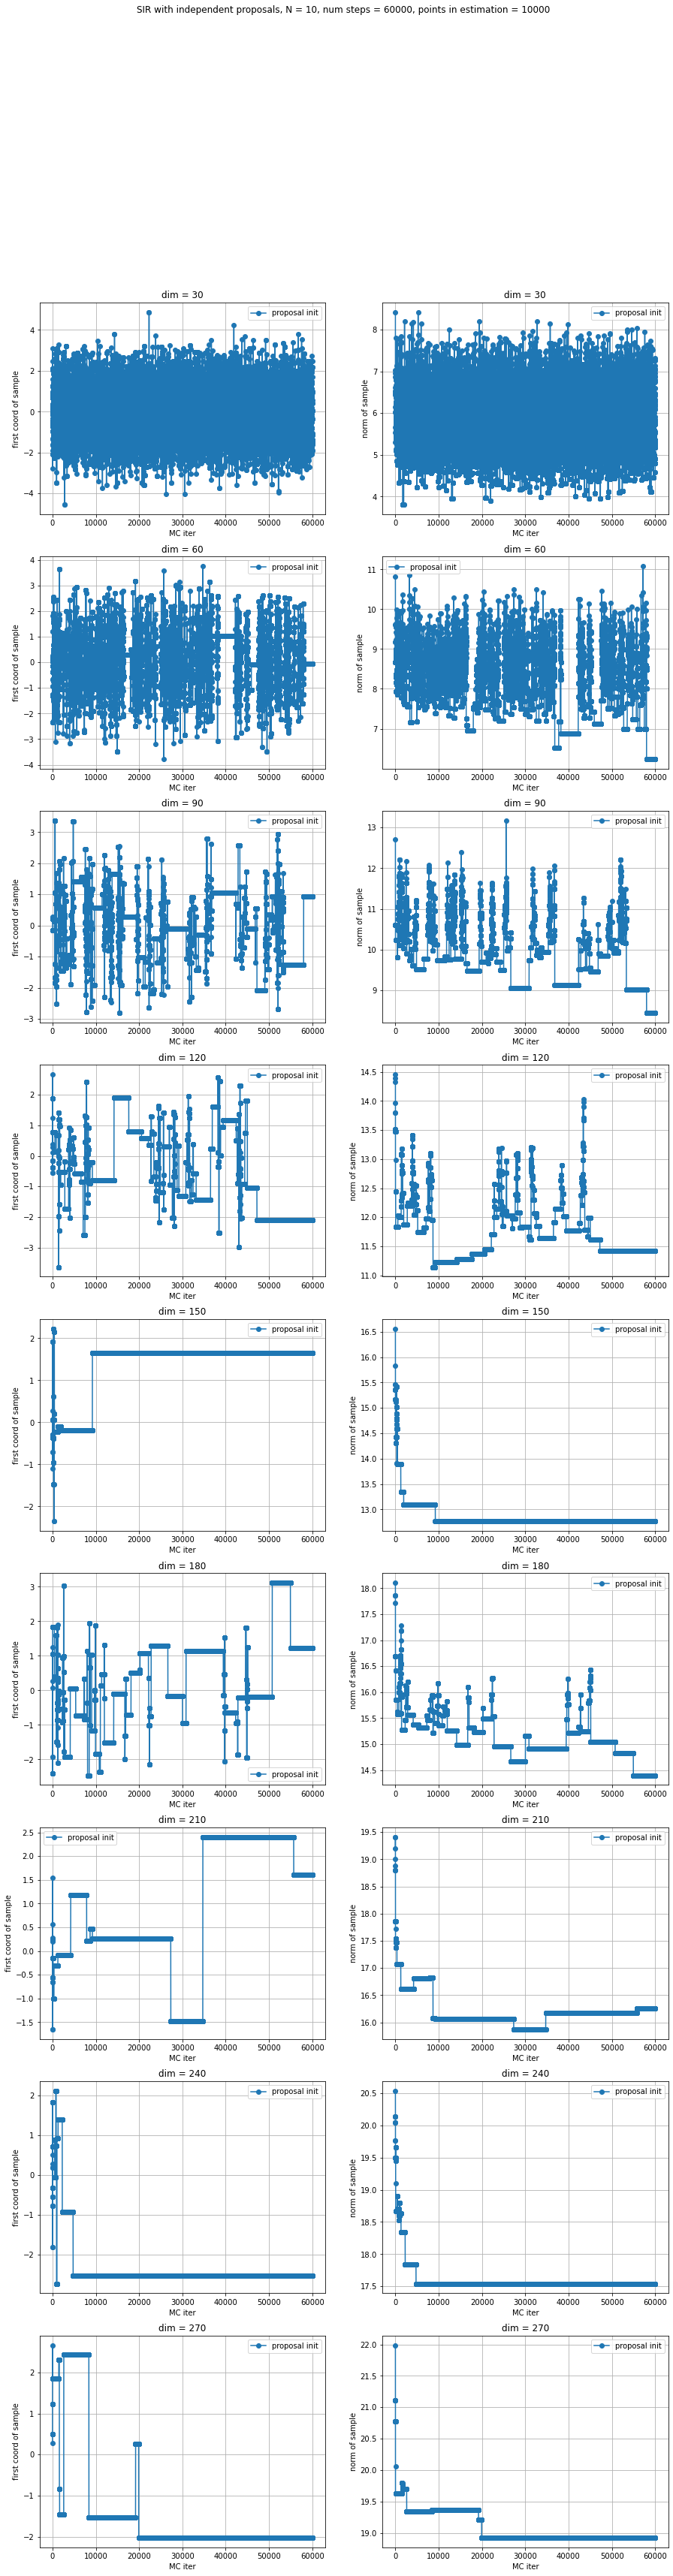

In [14]:
fig, axs = plt.subplots(ncols=2, nrows=len(dim_arr), figsize=(15, 55))
name = f'SIR with independent proposals, N = {N}, num steps = {n_steps}, points in estimation = {num_points_in_chain}'
fig.suptitle(name)

for i, dim in enumerate(dim_arr):
    axs[i][0].set_xlabel('MC iter')
    axs[i][0].set_ylabel('first coord of sample')
    #axs[i][0].plot(np.arange(len(dict_results['target']['history_first'][i])), 
    #               dict_results['target']['history_first'][i], 
    #               label=f'target init', marker='o')
    axs[i][0].plot(np.arange(len(results_independent['proposal']['history_first'][i])), 
                   results_independent['proposal']['history_first'][i], 
                   label=f'proposal init', marker='o')
    axs[i][0].set_title(f'dim = {dim}')
    axs[i][0].grid()
    axs[i][0].legend()

    axs[i][1].set_xlabel('MC iter')
    axs[i][1].set_ylabel('norm of sample')
    #axs[i][1].plot(np.arange(len(dict_results['target']['history_norm'][i])), 
    #               dict_results['target']['history_norm'][i], 
    #               label='target init', marker='o')
    axs[i][1].plot(np.arange(len(results_independent['proposal']['history_norm'][i])), 
                   results_independent['proposal']['history_norm'][i], 
                   label=f'proposal init', marker='o')
    axs[i][1].set_title(f'dim = {dim}')
    axs[i][1].grid()
    axs[i][1].legend()


plt.show()    

In [8]:
dim_arr = [30*(i + 1) for i in range(15)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1
n_steps = 60000
c = 1.0
N = 10
method_params = {'n_steps': n_steps, 'scale_proposal': scale_proposal, 'N': 10, 'c': c}
random_seed = 42
method = 'sir_correlated' 
print_results = True
results_corr = run_experiments_gaussians(dim_arr,  
                                         scale_proposal, 
                                         scale_target, 
                                         num_points_in_chain, 
                                         strategy_mean,
                                         device,
                                         batch_size,
                                         method_params,
                                         random_seed,
                                         method,
                                         print_results)

------------------
mode = target
dim = 30
mean estimation of variance = 0.986962616443634
mean estimation of mean = 0.013300567865371704
mean estimation of ess = 0.8476847684768477
------
dim = 60
mean estimation of variance = 0.9791516065597534
mean estimation of mean = 0.010116009041666985
mean estimation of ess = 0.845084508450845
------
dim = 90
mean estimation of variance = 0.9897153377532959
mean estimation of mean = 0.01252074632793665
mean estimation of ess = 0.8466846684668466
------
dim = 120
mean estimation of variance = 0.9745680093765259
mean estimation of mean = 0.010864601470530033
mean estimation of ess = 0.8420842084208421
------
dim = 150
mean estimation of variance = 0.9637556076049805
mean estimation of mean = 0.014357391744852066
mean estimation of ess = 0.8476847684768477
------
dim = 180
mean estimation of variance = 0.9604982137680054
mean estimation of mean = 0.012046149000525475
mean estimation of ess = 0.8444844484448445
------
dim = 210
mean estimation of va

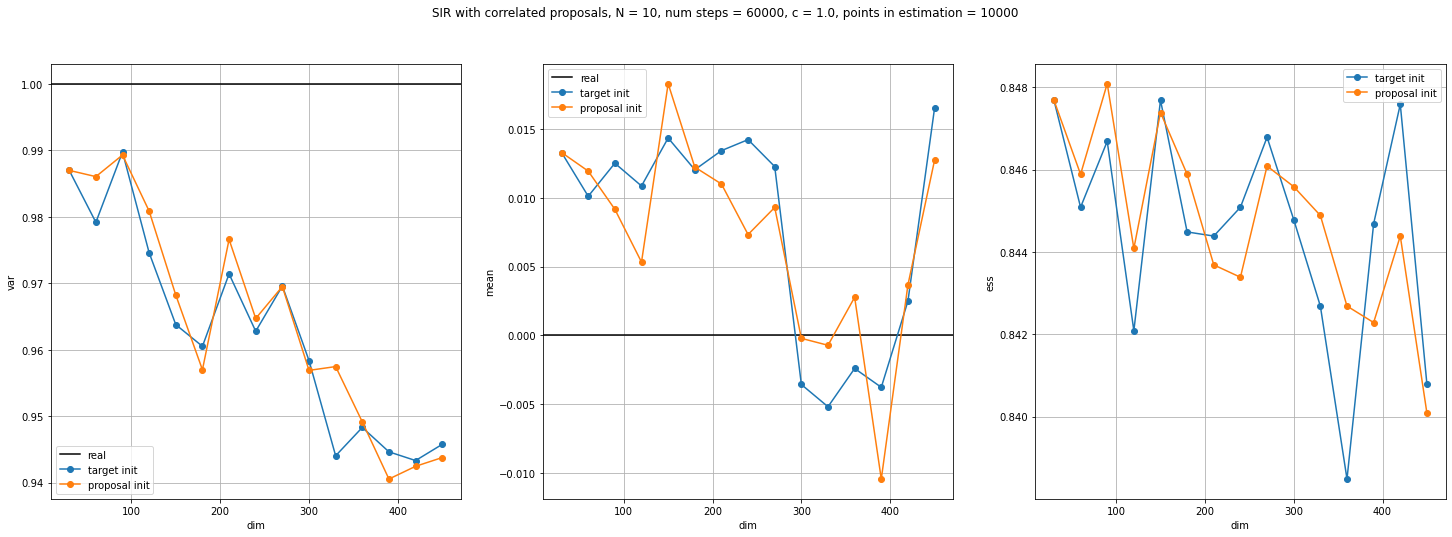

In [9]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(25, 8))
name = f'SIR with сorrelated proposals, N = {N}, num steps = {n_steps}, c = {c}, points in estimation = {num_points_in_chain}'
fig.suptitle(name)

axs[0].axhline(var_target, label='real', color='black')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('var')

axs[1].axhline(0.0, label='real', color='black')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('mean')

axs[2].set_xlabel('dim')
axs[2].set_ylabel('ess')

modes_to_plot = ['mean_var', 'mean_loc', 'ess']
for i, mode in enumerate(modes_to_plot):
    axs[i].plot(dim_arr, results_corr['target'][mode], label='target init', marker='o')
    axs[i].plot(dim_arr, results_corr['proposal'][mode], label='proposal init', marker='o')

for ax in axs:
    ax.grid()
    ax.legend()

plt.show()

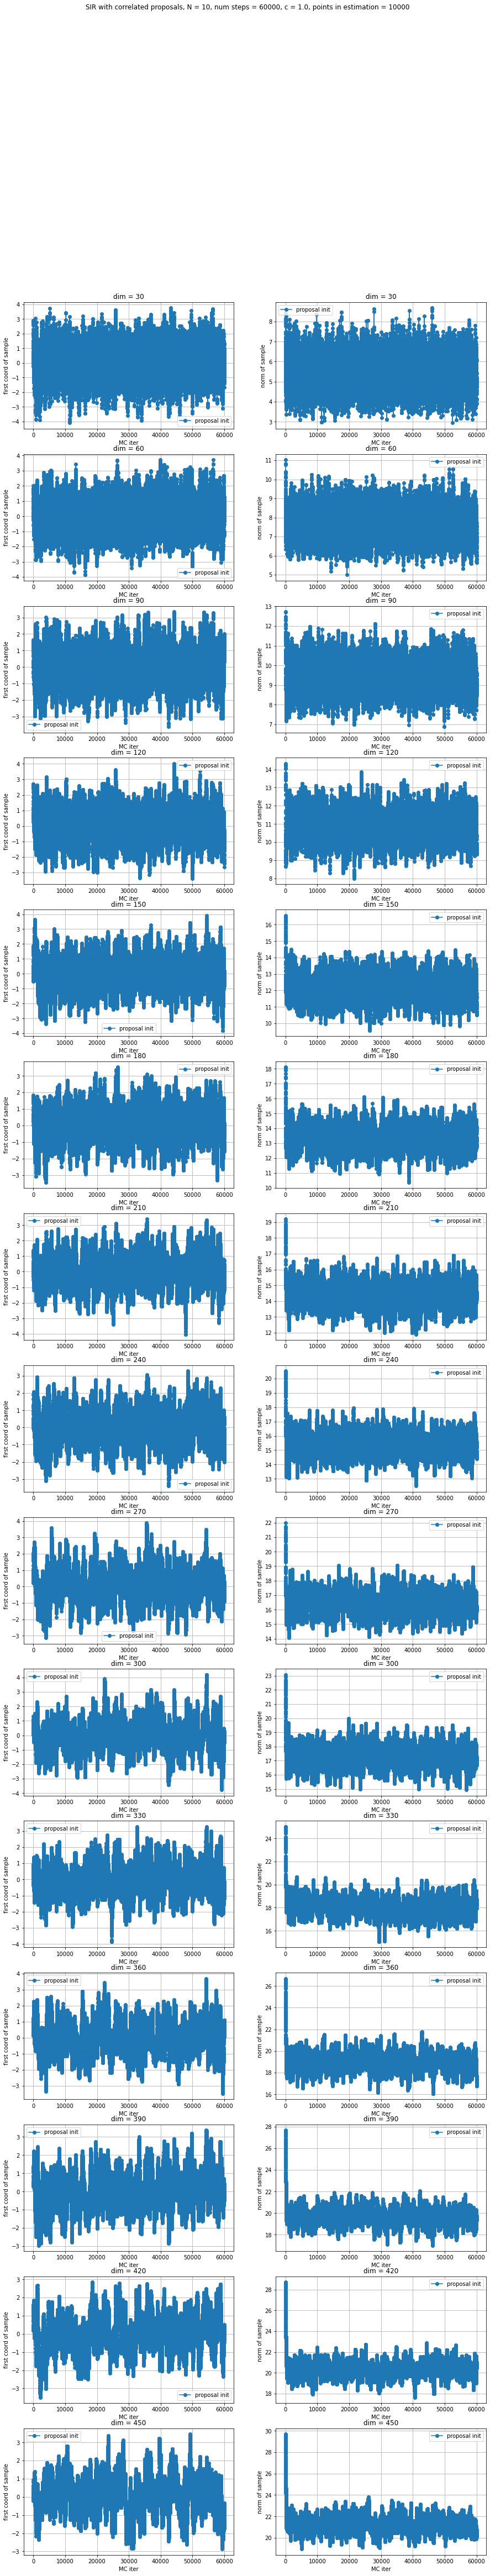

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=len(dim_arr), figsize=(15, 75))
name = f'SIR with сorrelated proposals, N = {N}, num steps = {n_steps}, c = {c}, points in estimation = {num_points_in_chain}'
fig.suptitle(name)

for i, dim in enumerate(dim_arr):
    axs[i][0].set_xlabel('MC iter')
    axs[i][0].set_ylabel('first coord of sample')
    axs[i][0].plot(np.arange(len(results_corr['proposal']['history_first'][i])), 
                   results_corr['proposal']['history_first'][i], 
                   label=f'proposal init', marker='o')
    axs[i][0].set_title(f'dim = {dim}')
    axs[i][0].grid()
    axs[i][0].legend()

    axs[i][1].set_xlabel('MC iter')
    axs[i][1].set_ylabel('norm of sample')
    axs[i][1].plot(np.arange(len(results_corr['proposal']['history_norm'][i])), 
                   results_corr['proposal']['history_norm'][i], 
                   label='proposal init', marker='o')
    axs[i][1].set_title(f'dim = {dim}')
    axs[i][1].grid()
    axs[i][1].legend()


plt.show()    

In [4]:
dim_arr = [30*(i + 1) for i in range(10)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 10
n_steps = 60000
c = 1.0
N = 10
method_params = {'n_steps': n_steps, 'scale_proposal': scale_proposal, 'N': 10, 'c': c}
random_seed = 42
method = 'sir_correlated' 
print_results = True
results_corr = run_experiments_gaussians(dim_arr,  
                                         scale_proposal, 
                                         scale_target, 
                                         num_points_in_chain, 
                                         strategy_mean,
                                         device,
                                         batch_size,
                                         method_params,
                                         random_seed,
                                         method,
                                         print_results)

------------------
mode = target
dim = 30
mean estimation of variance = 0.9999545812606812
mean estimation of mean = 0.0006337745580822229
mean estimation of ess = 0.8512051205120512
------
dim = 60
mean estimation of variance = 0.9934698343276978
mean estimation of mean = 0.0014841973315924406
mean estimation of ess = 0.8499649964996501
------
dim = 90
mean estimation of variance = 0.995296061038971
mean estimation of mean = -0.0018702051602303982
mean estimation of ess = 0.8497849784978498
------
dim = 120
mean estimation of variance = 0.9786173105239868
mean estimation of mean = -0.0013981913216412067
mean estimation of ess = 0.8508350835083508
------
dim = 150
mean estimation of variance = 0.9845097064971924
mean estimation of mean = 0.0014699888415634632
mean estimation of ess = 0.8501750175017502
------
dim = 180
mean estimation of variance = 0.9754686951637268
mean estimation of mean = 0.0032223621383309364
mean estimation of ess = 0.8485648564856486
------
dim = 210
mean estima

# SIR, target = 2 gaussians

In [67]:
a = torch.ones((2, 2, 2))

In [69]:
a[0].shape

torch.Size([2, 2])

In [16]:
def sir_independent_dynamics(z, target, proposal, n_steps, N):
    z_sp = []
    batch_size, z_dim = z.shape[0], z.shape[1]

    for _ in range(n_steps):
        z_sp.append(z)
        U = torch.randint(0, N, (batch_size,)).tolist()
        X = proposal.sample([batch_size, N])
        X[np.arange(batch_size), U, :] = z
        X_view = X.view(-1, z_dim)

        log_weight = compute_sir_log_weights(X_view, target, proposal)
        log_weight = log_weight.view(batch_size, N)
        
        max_logs = torch.max(log_weight, dim = 1)[0][:, None]
        log_weight = log_weight - max_logs
        weight = torch.exp(log_weight)
        sum_weight = torch.sum(weight, dim = 1)
        weight = weight/sum_weight[:, None]

        weight[weight != weight] = 0.
        weight[weight.sum(1) == 0.] = 1.

        indices = torch.multinomial(weight, 1).squeeze().tolist()

        z = X[np.arange(batch_size), indices, :]
        z = z.data

    z_sp.append(z)
    return z_sp

In [17]:
def compute_sir_log_weights(x, target, proposal):
    return target.log_prob(x) -  proposal.log_prob(x)

def sir_correlated_dynamics(z, target, proposal, n_steps, N, alpha):
    z_sp = []
    batch_size, z_dim = z.shape[0], z.shape[1]

    for _ in range(n_steps):
        z_sp.append(z)
        z_copy = z.unsqueeze(1).repeat(1, N, 1)
        ind = torch.randint(0, N, (batch_size,)).tolist()
        W = proposal.sample([batch_size, N])
        U = proposal.sample([batch_size]).unsqueeze(1).repeat(1, N, 1)
        #print(W.shape, U.shape, z_copy.shape)
        X = torch.zeros((batch_size, N, z_dim), dtype = z.dtype).to(z.device)
        X =  (alpha**2)*z_copy + alpha*((1- alpha**2)**0.5)*U + W*((1- alpha**2)**0.5)
        X[np.arange(batch_size), ind, :] = z
        X_view = X.view(-1, z_dim)

        log_weight = compute_sir_log_weights(X_view, target, proposal)
        log_weight = log_weight.view(batch_size, N)
        max_logs = torch.max(log_weight, dim = 1)[0][:, None]
        log_weight = log_weight - max_logs
        weight = torch.exp(log_weight)
        sum_weight = torch.sum(weight, dim = 1)
        weight = weight/sum_weight[:, None]        

        weight[weight != weight] = 0.
        weight[weight.sum(1) == 0.] = 1.

        indices = torch.multinomial(weight, 1).squeeze().tolist()

        z = X[np.arange(batch_size), indices, :]
        z = z.data

    z_sp.append(z)
    return z_sp

In [18]:
def run_experiments_2_gaussians(dim_arr,  
                                scale_proposal, 
                                scale_target,
                                loc_1_target,
                                loc_2_target,
                                num_points_in_chain, 
                                strategy_mean,
                                device,
                                batch_size,
                                method_params,
                                random_seed=42,
                                method='sir_independent',
                                print_results=True):
    modes_init = ['target', 'proposal']
    dict_results = {'target': {'mean_loc_1': [],
                               'mean_loc_2': [],
                               'mean_var': [], 
                               'mean_jsd': [],
                               'mean_hqr': [],
                               'ess': [], 
                               'history_first': [],            
                               'history_norm': []}, 
                    'proposal': {'mean_loc_1': [], 
                                 'mean_loc_2': [],
                                 'mean_var': [], 
                                 'mean_jsd': [],
                                 'mean_hqr': [],
                                 'ess': [], 
                                 'history_first': [], 
                                 'history_norm': []}}
    
    for mode_init in modes_init:
       if print_results:
          print("------------------")
          print(f"mode = {mode_init}")
    
       for dim in dim_arr:
          if print_results:
             print(f"dim = {dim}")
          
          target_args = DotDict()
          target_args.device = device
          target_args.num_gauss = 2

          coef_gaussian = 1./target_args.num_gauss
          target_args.p_gaussians = [torch.tensor(coef_gaussian)]*target_args.num_gauss
          locs = [loc_1_target*torch.ones(dim, dtype = torch.float64).to(device),
                  loc_2_target*torch.ones(dim, dtype = torch.float64).to(device)]
          locs_numpy = torch.stack(locs, axis = 0).cpu().numpy()
          target_args.locs = locs
          target_args.covs = [(scale_target**2)*torch.eye(dim, 
                                                          dtype = torch.float64).to(device)]*target_args.num_gauss
          target_args.dim = dim
          target = Gaussian_mixture(target_args)
          proposal = init_independent_normal(scale_proposal, dim, device)
          torch.manual_seed(random_seed)
          np.random.seed(random_seed)
          random.seed(random_seed)
          if mode_init == 'target':
             dataset = sklearn.datasets.make_blobs(n_samples = batch_size, 
                                                   n_features = dim, 
                                                   centers = locs_numpy, 
                                                   cluster_std = scale_target,
                                                   random_state = random_seed)[0]
             start = torch.FloatTensor(dataset).to(device)
          elif mode_init == 'proposal':
             start = proposal.sample([batch_size])
          #print(f"start = {start}")
          if method == 'sir_correlated':
             alpha = (1 - method_params['c']/dim)**0.5
             history = sir_correlated_dynamics(start, 
                                               target,
                                               proposal, 
                                               method_params['n_steps'], 
                                               method_params['N'],
                                               alpha)
          elif method == 'sir_independent':
             history = sir_independent_dynamics(start, 
                                                target,
                                                proposal, 
                                                method_params['n_steps'], 
                                                method_params['N'])
          else:
             raise ValueError('Unknown method')    
          last_history = history[(-num_points_in_chain - 1):-1]
          all_history_np = torch.stack(history, axis = 0).cpu().numpy()
          torch_last_history = torch.stack(last_history, axis = 0).cpu()
          
          evolution = Evolution(None, locs=torch.stack(locs, 0).cpu(), sigma=scale_target)  

          result_np = torch.stack(last_history, axis = 0).cpu().numpy()
          if strategy_mean == 'starts':
             mode_var_arr = []
             modes_mean_arr = []
             h_q_r_arr = []
             jsd_arr = []
             means_est_1 = torch.zeros(dim)
             means_est_2 = torch.zeros(dim)
             num_found_1_mode = 0
             num_found_2_mode = 0
            
             for i in range(num_points_in_chain):
                X_gen = torch_last_history[i, :, :]
                assignment = Evolution.make_assignment(X_gen, evolution.locs, evolution.sigma)
                mode_var = Evolution.compute_mode_std(X_gen, assignment).item()**2
                modes_mean, found_modes_ind = Evolution.compute_mode_mean(X_gen, assignment)
                if 0 in found_modes_ind:
                   num_found_1_mode += 1
                   means_est_1 += modes_mean[0]
                if 1 in found_modes_ind:
                   num_found_2_mode += 1
                   means_est_2 += modes_mean[1]
                
                h_q_r = Evolution.compute_high_quality_rate(assignment).item()
                jsd = Evolution.compute_jsd(assignment).item()
                
                mode_var_arr.append(mode_var)
                modes_mean_arr.append(modes_mean)
                h_q_r_arr.append(h_q_r)
                jsd_arr.append(jsd)
             jsd_result = np.array(jsd_arr).mean()
             mode_var_result = np.array(modes_var_arr).mean()
             h_q_r_result = np.array(h_q_r_arr).mean()
             modes_mean_1_result = (means_est_1/num_found_1_mode).mean().item()
             modes_mean_2_result = (means_est_2/num_found_2_mode).mean().item()

          elif strategy_mean == 'chain':
             modes_var_arr = []
             modes_mean_arr = []
             h_q_r_arr = []
             jsd_arr = []
             means_est_1 = torch.zeros(dim)
             means_est_2 = torch.zeros(dim)
             num_found_1_mode = 0
             num_found_2_mode = 0
             
             #print(evolution.locs)
             for i in range(batch_size):
                X_gen = torch_last_history[:, i, :]
                assignment = Evolution.make_assignment(X_gen, evolution.locs, evolution.sigma)
                mode_var = Evolution.compute_mode_std(X_gen, assignment).item()**2
                
                modes_mean, found_modes_ind = Evolution.compute_mode_mean(X_gen, assignment)
                #print(f"found_modes_ind = {found_modes_ind}")
                if 0 in found_modes_ind:
                   num_found_1_mode += 1
                   means_est_1 += modes_mean[0]
                if 1 in found_modes_ind:
                   num_found_2_mode += 1
                   means_est_2 += modes_mean[1]
                #print(f"batch = {i}, modes_mean = {modes_mean}")
                h_q_r = Evolution.compute_high_quality_rate(assignment).item()
                jsd = Evolution.compute_jsd(assignment).item()
                
                modes_var_arr.append(mode_var)

                h_q_r_arr.append(h_q_r)
                jsd_arr.append(jsd)
             jsd_result = np.array(jsd_arr).mean()
             modes_var_result = np.array(modes_var_arr).mean()
             h_q_r_result = np.array(h_q_r_arr).mean()
             #modes_mean_result = torch.stack(modes_mean_arr, axis = 0).cpu().numpy()
             #print(modes_mean_result.shape)
             #modes_mean_result = modes_mean_result.mean(0).mean(1)
             #print(f"num_found_1_mode = {num_found_1_mode}")
             #print(f"num_found_2_mode = {num_found_2_mode}")
             modes_mean_1_result = (means_est_1/num_found_1_mode).mean().item()
             modes_mean_2_result = (means_est_2/num_found_2_mode).mean().item()

          else:
             raise ValueError('Unknown method of mean') 

          result_np_1 = result_np[:-1]
          result_np_2 = result_np[1:]
          diff = (result_np_1 == result_np_2).sum(axis = 2)
          ess_bs = (diff != dim).mean(axis = 0)
          ess = ess_bs.mean()
          first_coord_history = all_history_np[:, :, 0]
          norm_history = np.linalg.norm(all_history_np, axis = -1)

          if print_results:
             print(f"mean estimation of target variance = {modes_var_result}")
             print(f"mean estimation of 1 mode mean  = {modes_mean_1_result}")
             print(f"mean estimation of 2 mode mean  = {modes_mean_2_result}")
             print(f"mean estimation of JSD  = {jsd_result}")
             print(f"mean estimation of HQR  = {h_q_r_result}")
             print(f"mean estimation of ESS = {ess}")
             print("------")
          dict_results[mode_init]['mean_loc_1'].append(modes_mean_1_result)
          dict_results[mode_init]['mean_loc_2'].append(modes_mean_2_result)
          dict_results[mode_init]['mean_var'].append(modes_var_result)
          dict_results[mode_init]['mean_jsd'].append(jsd_result)
          dict_results[mode_init]['mean_hqr'].append(h_q_r_result)
          dict_results[mode_init]['ess'].append(ess)
          dict_results[mode_init]['history_first'].append(first_coord_history)
          dict_results[mode_init]['history_norm'].append(norm_history)
    
    return dict_results


In [6]:
dim_arr = [30*(i + 1) for i in range(10)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
loc_1_target = 1.0
loc_2_target = -1.0

num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 10
n_steps = 30000
c = 1.0
N = 10
method_params = {'n_steps': n_steps, 'scale_proposal': scale_proposal, 'N': 10, 'c': c}
random_seed = 42
method = 'sir_correlated' 
print_results = True
results_corr = run_experiments_2_gaussians(dim_arr,  
                                           scale_proposal, 
                                           scale_target,
                                           loc_1_target,
                                           loc_2_target,
                                           num_points_in_chain, 
                                           strategy_mean,
                                           device,
                                           batch_size,
                                           method_params,
                                           random_seed,
                                           method,
                                           print_results)

------------------
mode = target
dim = 30
mean estimation of target variance = 0.9612596021069055
mean estimation of 1 mode mean  = 0.9976850152015686
mean estimation of 2 mode mean  = -0.9965546727180481
mean estimation of JSD  = 0.036087562888860704
mean estimation of HQR  = 0.954339998960495
mean estimation of ESS = 0.7917591759175918
------
dim = 60
mean estimation of target variance = 0.9679708709137238
mean estimation of 1 mode mean  = 0.9934738278388977
mean estimation of 2 mode mean  = -1.0099217891693115
mean estimation of JSD  = 0.03620938807725906
mean estimation of HQR  = 0.9551999986171722
mean estimation of ESS = 0.7904990499049906
------
dim = 90
mean estimation of target variance = 0.9784258677445095
mean estimation of 1 mode mean  = 0.9969713091850281
mean estimation of 2 mode mean  = -1.0050169229507446
mean estimation of JSD  = 0.03494294732809067
mean estimation of HQR  = 0.9457800030708313
mean estimation of ESS = 0.7907690769076908
------
dim = 120
mean estimation

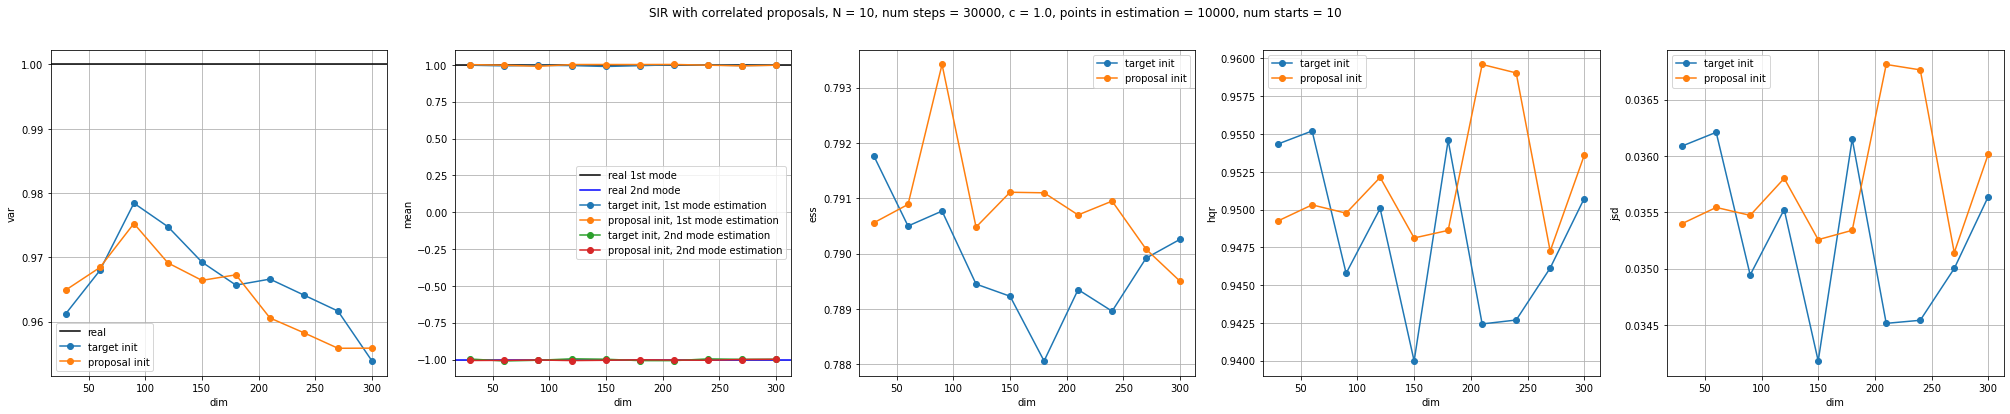

In [14]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(35, 6))
name = f'SIR with сorrelated proposals, N = {N}, num steps = {n_steps}, c = {c}, points in estimation = {num_points_in_chain}, num starts = {batch_size}'
fig.suptitle(name)

axs[0].axhline(var_target, label='real', color='black')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('var')

axs[1].axhline(loc_1_target, label='real 1st mode', color='black')
axs[1].axhline(loc_2_target, label='real 2nd mode', color='blue')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('mean')

axs[2].set_xlabel('dim')
axs[2].set_ylabel('ess')

axs[3].set_xlabel('dim')
axs[3].set_ylabel('hqr')

axs[4].set_xlabel('dim')
axs[4].set_ylabel('jsd')

modes_to_plot = ['mean_var', 'mean_loc_1', 'mean_loc_2', 'ess', 'mean_hqr', 'mean_jsd']
for i, mode in enumerate(modes_to_plot):
    if i == 1:
        axs[i].plot(dim_arr, results_corr['target']['mean_loc_1'], 
                    label='target init, 1st mode estimation', marker='o')
        axs[i].plot(dim_arr, results_corr['proposal']['mean_loc_1'], 
                    label='proposal init, 1st mode estimation', marker='o')
        axs[i].plot(dim_arr, results_corr['target']['mean_loc_2'], 
                    label='target init, 2nd mode estimation', marker='o')
        axs[i].plot(dim_arr, results_corr['proposal']['mean_loc_2'], 
                    label='proposal init, 2nd mode estimation', marker='o')
    elif i == 2:
        pass
    else:
        if i == 0:
            j = 0
        else:
            j = i - 1
        axs[j].plot(dim_arr, results_corr['target'][mode], label='target init', marker='o')
        axs[j].plot(dim_arr, results_corr['proposal'][mode], label='proposal init', marker='o')
    
for ax in axs:
    ax.grid()
    ax.legend()

plt.show()

In [19]:
dim_arr = [30*(i + 1) for i in range(10)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
loc_1_target = 1.0
loc_2_target = -1.0

num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 10
n_steps = 30000
c = 1.0
N = 10
method_params = {'n_steps': n_steps, 'scale_proposal': scale_proposal, 'N': 10, 'c': c}
random_seed = 42
method = 'sir_independent' 
print_results = True
results_corr = run_experiments_2_gaussians(dim_arr,  
                                           scale_proposal, 
                                           scale_target,
                                           loc_1_target,
                                           loc_2_target,
                                           num_points_in_chain, 
                                           strategy_mean,
                                           device,
                                           batch_size,
                                           method_params,
                                           random_seed,
                                           method,
                                           print_results)

------------------
mode = target
dim = 30
mean estimation of target variance = 0.5177300910103673
mean estimation of 1 mode mean  = 0.8630160093307495
mean estimation of 2 mode mean  = -0.8818822503089905
mean estimation of JSD  = 0.044360130093991756
mean estimation of HQR  = 0.9425499975681305
mean estimation of ESS = 0.0037703770377037703
------
dim = 60
mean estimation of target variance = 7.373292264391776e-14
mean estimation of 1 mode mean  = 0.9944514036178589
mean estimation of 2 mode mean  = -1.0214898586273193
mean estimation of JSD  = 0.04247488081455231
mean estimation of HQR  = 1.0
mean estimation of ESS = 0.0
------
dim = 90
mean estimation of target variance = 7.426876359800128e-14
mean estimation of 1 mode mean  = 1.01462721824646
mean estimation of 2 mode mean  = -0.9778567552566528
mean estimation of JSD  = 0.04247488081455231
mean estimation of HQR  = 1.0
mean estimation of ESS = 0.0
------
dim = 120
mean estimation of target variance = 7.118772735836129e-14
mean est

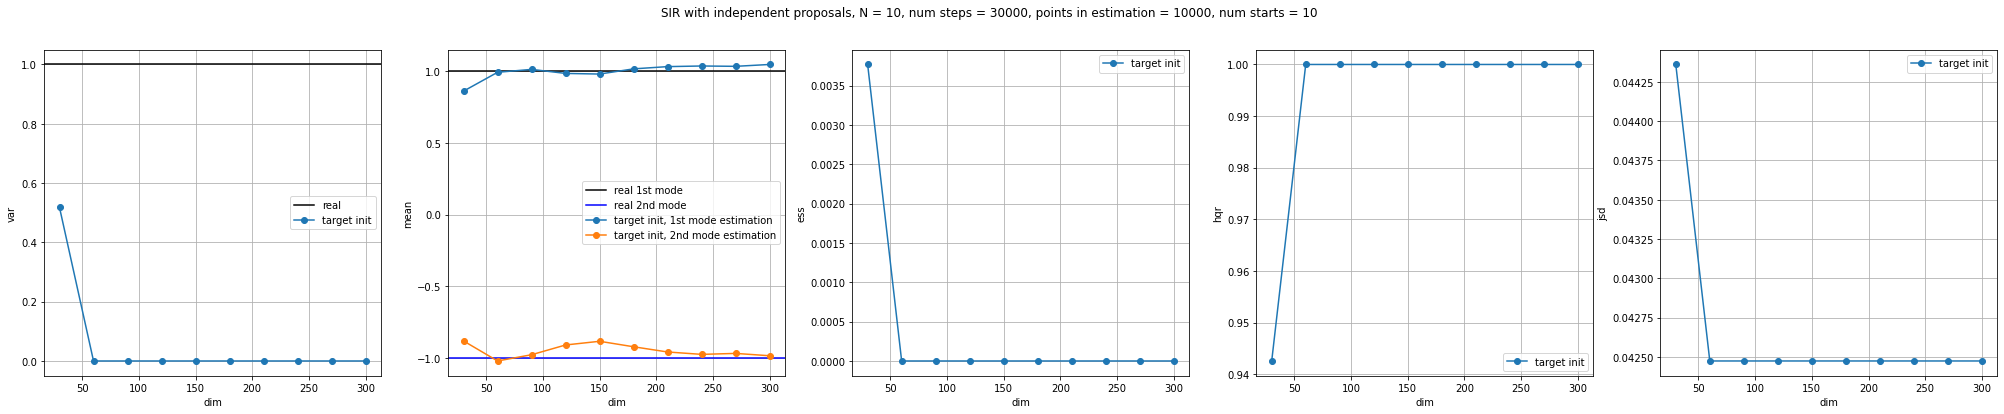

In [21]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(35, 6))
name = f'SIR with independent proposals, N = {N}, num steps = {n_steps}, points in estimation = {num_points_in_chain}, num starts = {batch_size}'
fig.suptitle(name)

axs[0].axhline(var_target, label='real', color='black')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('var')

axs[1].axhline(loc_1_target, label='real 1st mode', color='black')
axs[1].axhline(loc_2_target, label='real 2nd mode', color='blue')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('mean')

axs[2].set_xlabel('dim')
axs[2].set_ylabel('ess')

axs[3].set_xlabel('dim')
axs[3].set_ylabel('hqr')

axs[4].set_xlabel('dim')
axs[4].set_ylabel('jsd')

modes_to_plot = ['mean_var', 'mean_loc_1', 'mean_loc_2', 'ess', 'mean_hqr', 'mean_jsd']
for i, mode in enumerate(modes_to_plot):
    if i == 1:
        axs[i].plot(dim_arr, results_corr['target']['mean_loc_1'], 
                    label='target init, 1st mode estimation', marker='o')
        axs[i].plot(dim_arr, results_corr['target']['mean_loc_2'], 
                    label='target init, 2nd mode estimation', marker='o')
    elif i == 2:
        pass
    else:
        if i == 0:
            j = 0
        else:
            j = i - 1
        axs[j].plot(dim_arr, results_corr['target'][mode], label='target init', marker='o')
    
for ax in axs:
    ax.grid()
    ax.legend()

plt.show()

In [ ]:
target std estimation: for all starts and for all modes I found last 10k points in the chain = X that were assigned to this mode and estimated std in this mode as sqrt(norm(X - mean(X))^2/d/(n - 1)). After that I computed mean of stds for all modes that has at least 1 assigned points of dataset. I found that for 1 given start the chain converges only to 1 mode, that's why we need to take more than 1 start to found both modes (I made 10 parallel starts). Lastly, I computed result std for given dim as mean of estimations for all starts. In the same way I estimated means of modes. 
more details: I have tensor with shape (num_starts, num_points in chain, dim) = (10, 10k, dim). For each of 10 start I have X as tensor (10k, dim). For both modes I divided this tensor into 3 parts: assigned to 1st mode/2nd mode/weren't assign. In practice only 1 mode has assigned points, so I obtain 10 estimations of target std in this mode and then use their mean as the result. If both modes have assigned points, I estimate std for X as (std1 + std2)/2 and then take their mean out of 10 starts. For mean estimation of X I used componentwise mean(X). After that I summed up these estimations for all starts and result vector mean estimation was obtained as ratio of this sum to to the number of times the mod was discovered during all starts. JSD/HQR was computed in the same way as mean for 10 starts of assignments for each X. 